In [6]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from PIL import Image
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import faiss

def index_image_paths(folder):
    image_paths = []
    for synset in os.listdir(folder):
        subfolder = os.path.join(folder, synset)
        if os.path.isdir(subfolder):
            for image_name in os.listdir(subfolder):
                image_paths.append(os.path.join(subfolder, image_name))

    return np.array(image_paths)

def read_transcript(filename):
    with open(filename, 'r', encoding="utf-8") as transcript:
        return transcript.read()

SRC_DIR = r"..\Django\ground_truth_videography_project"

In [2]:
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
print(device)
print(torch.cuda.get_device_name(0))

tokeniser = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

cuda
NVIDIA GeForce GTX 1650


In [7]:
filter = [516621, 653283, 589736, 630260, 590689, 516333, 701639, 538449, 558009, 1017551, 590174, 558027, 590157, 559003, 604023, 572346, 661681, 993150, 1018475, 792565, 1054980, 993647, 515930, 1279994, 1122816, 1122783, 1122318, 559453, 1122669, 1017594, 1122462, 558741, 558533, 559600, 1121668, 1121871, 1122352, 558838, 559166, 559573, 1122659, 1122602, 1147593, 590688, 766038, 589621, ]

image_paths = np.delete(index_image_paths(os.path.join(SRC_DIR, "imagenet-1k")), filter)
print(len(image_paths))

image_vectors = np.load(os.path.join(SRC_DIR, r"videography_pipeline\image_vectors\imagenet-1k-vecs-FILTERED.npy"))
print(image_vectors.shape)

1281121
(1281121, 512)


# FAISS - Efficient Similarity Searching

In [ ]:
d = image_vectors.shape[1]
vecs = faiss.IndexFlatIP(d)
m = 8
nlist = 2048
nbits = 8
index = faiss.IndexIVFPQ(vecs, d, nlist, m, nbits)


index.train(image_vectors)
print(index.is_trained)

index.add(image_vectors)
print(index.ntotal)

# faiss.write_index(index, r"faiss_index\faiss_image_vecs_{nlist}"))

In [5]:
index = faiss.read_index(r"faiss_index\faiss_image_vecs_{nlist}")

In [ ]:
prompt = "dogs"
inputs = tokeniser(prompt, return_tensors="pt").to(device)
text_emb = model.get_text_features(**inputs)

text_emb = text_emb.cpu().detach().numpy()

# scores = np.dot(text_emb, image_vectors.T)
# print(scores)

# best = np.argsort(-scores[0])[:10]
# print(best)
# for i in best:
#     print(f"{image_paths[i]} ({i}): {scores[0][i]}")
#     with Image.open(image_paths[i]) as image:
#         plt.imshow(image, cmap='gray')
#         plt.show()

index.nprobe = 10
k = 10
dists, I = index.search(text_emb, k)
print(I)

for id, i in enumerate(I[0]):
    print(f"{image_paths[i]} ({i}): {dists[0, id]}")
    with Image.open(image_paths[i]) as image:
        plt.imshow(image, cmap='gray')
        plt.show()

# FAISS Analysis vs. Exhaustive Search

In [11]:
import pylrc

lyrics = pylrc.parse(read_transcript(os.path.join(SRC_DIR, r"videography_pipeline\transcript\Tw0zYd0eIlk.lrc")))
texts = list([lyric.text for lyric in lyrics if lyric.text != '♪'])
print(texts)

['Day off in Kyoto', 'Got bored at the temple', 'Looked around at the 7-Eleven', 'The band took the speed train', 'Went to the arcade', "I wanted to go, but I didn't", 'You called me from a payphone', 'They still got payphones', 'It cost a dollar a minute', "To tell me you're getting sober", 'And you wrote me a letter', "But I don't have to read it", "I'm gonna kill you", "If you don't beat me to it", 'Dreaming through Tokyo skies', 'I wanted to see the world', 'Then I flew over the ocean', 'And I changed my mind (woo)', "Sunset's been a freak show", 'On the weekend, so', "I've been driving out to the suburbs", 'To park at the Goodwill', 'And stare at the chemtrails', 'With my little brother', 'He said you called on his birthday', 'You were off by like ten days', "But you get a few points for tryin'", 'Remember getting the truck fixed', 'When you let us drive it', 'Twenty-five felt like flying', "I don't forgive you", "But please don't hold me to it", 'Born under Scorpio skies', 'I wan

## Exhaustive Search

In [ ]:
import time
import json

exhaustive = {
    'image_ids': [],
    'runtimes': [],
}
for text in texts:
    inputs = tokeniser(text, return_tensors="pt").to(device)
    text_emb = model.get_text_features(**inputs).cpu().detach().numpy()

    start = time.time()
    scores = np.dot(text_emb, image_vectors.T)
    best = np.argsort(-scores[0])[:10]
    end = time.time()

    exhaustive['image_ids'].append(best.tolist())
    exhaustive['runtimes'].append(end - start)

print(exhaustive['runtimes'])

In [13]:
with open(r"faiss_analysis/exhaustive.json", "w", encoding='utf-8') as file:
    json.dump(exhaustive, file, ensure_ascii=False)

## FAISS Search

In [ ]:
import time
import json

faiss_res = {
    'image_ids': [],
    'runtimes': [],
}

nlist = 2048
index = faiss.read_index(fr"faiss_index\faiss_image_vecs_{nlist}")
index.nprobe = 10

for text in texts:
    inputs = tokeniser(text, return_tensors="pt").to(device)
    text_emb = model.get_text_features(**inputs).cpu().detach().numpy()

    start = time.time()
    dists, res = index.search(text_emb, 10)
    end = time.time()

    faiss_res['image_ids'].append(res[0].tolist())
    faiss_res['runtimes'].append(end - start)

print(faiss_res['runtimes'])

In [7]:
with open(fr"faiss_analysis/faiss_{nlist}.json", "w", encoding='utf-8') as file:
    json.dump(faiss_res, file, ensure_ascii=False)

## Analysis

In [ ]:
import json

with open(r"faiss_analysis/exhaustive.json", "r", encoding='utf-8') as file:
    exhaustive = json.load(file)

nlist = 2048
with open(fr"faiss_analysis/faiss_{nlist}.json", "r", encoding='utf-8') as file:
    faiss_res = json.load(file)

exhaustive['image_ids'] = np.array(exhaustive['image_ids'])
exhaustive['runtimes'] = np.array(exhaustive['runtimes'])
faiss_res['image_ids'] = np.array(faiss_res['image_ids'])
faiss_res['runtimes'] = np.array(faiss_res['runtimes'])

In [31]:
print("MEAN RUNTIMES")
print(f"  Exhaustive Search: {exhaustive['runtimes'].mean():.4f}s")
print(f"  FAISS Search (nlist={nlist}): {faiss_res['runtimes'].mean():.4f}s")

print("\nTOTAL RUNTIMES")
print(f"  Exhaustive Search: {exhaustive['runtimes'].sum():.4f}s")
print(f"  FAISS Search (nlist={nlist}): {faiss_res['runtimes'].sum():.4f}s")

MEAN RUNTIMES
  Exhaustive Search: 0.3404s
  FAISS Search (nlist=2048): 0.0026s

TOTAL RUNTIMES
  Exhaustive Search: 13.6168s
  FAISS Search (nlist=2048): 0.1048s


In [20]:
def jaccard_sim(x, y):
    intersection = set(x).intersection(set(y))
    return len(intersection)/(len(x) + len(y) - len(intersection))

jaccard_similarities = np.array([jaccard_sim(a, b) for a in exhaustive['image_ids'] for b in faiss_res['image_ids']])
print(jaccard_similarities)
print(f"MEAN JACCARD SIMILARITY: {jaccard_similarities.mean()}")

[0. 0. 0. ... 0. 0. 0.]
MEAN JACCARD SIMILARITY: 0.0


Day off in Kyoto


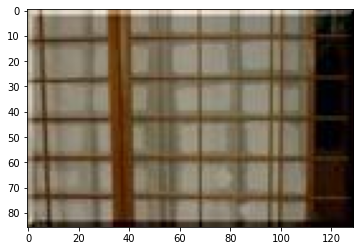

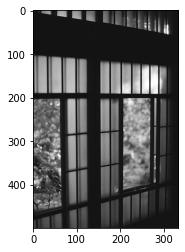

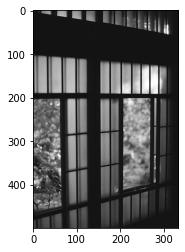

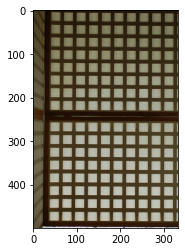

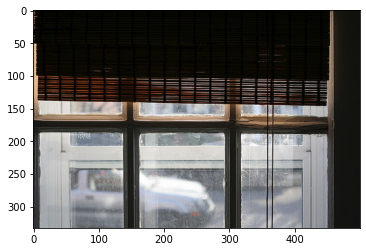

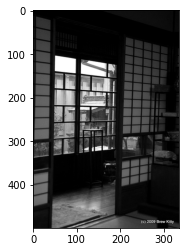

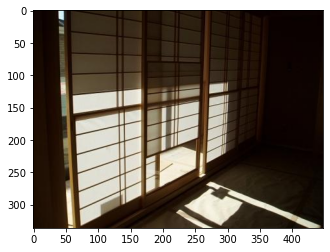

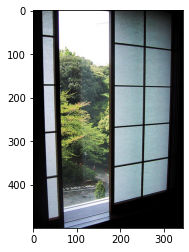

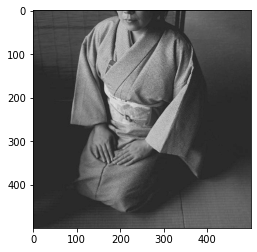

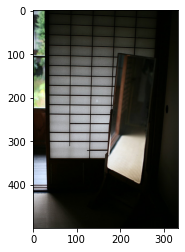

In [34]:
id = 0
print(texts[id])
for i in exhaustive['image_ids'][id]:
    with Image.open(image_paths[i]) as image:
        plt.imshow(image, cmap='gray')
        plt.show()